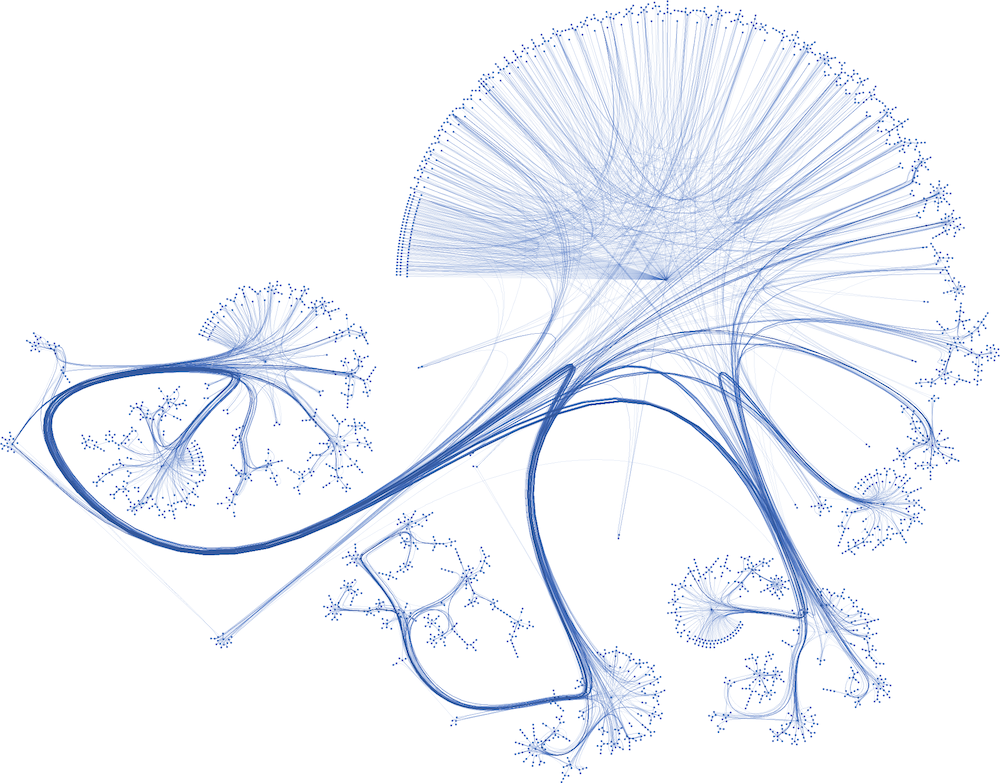

In [1]:
import tensorflow.compat.v1 as tf1
# import tensorflow as tf2
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
session = tf1.Session(config=config)

2024-10-04 07:49:16.231865: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-04 07:49:16.503311: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-04 07:49:17.509121: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-10-04 07:49:19.149642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24315 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:3b:00.0, compute capab

# 
# 1.
### Cora dataset 다운로드

In [2]:
import urllib.request
import os
import tarfile
import numpy as np
import networkx as nx
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import normalize, LabelEncoder
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.manifold import SpectralEmbedding


# Download and extract Cora dataset
def download_cora_dataset():
    url = 'https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz'
    dataset_dir = 'cora'
    
    if not os.path.exists(dataset_dir):
        os.makedirs(dataset_dir)
    
    tgz_path = os.path.join(dataset_dir, 'cora.tgz')
    
    if not os.path.exists(tgz_path):
        urllib.request.urlretrieve(url, tgz_path)
        
        with tarfile.open(tgz_path, 'r:gz') as tar:
            tar.extractall(path=dataset_dir)
#download_cora_dataset()

# 
# 2. 
### Cora 데이터셋에서 연결정보(adjacency matrix) G , node_map (feature node matrix), labels (논문 유형) 로드

In [3]:
# Load Cora dataset
def load_data():
    cites_path = "/home/oem/KYM/Graph Neural Network/cora/cora/cora.cites"
    content_path = "/home/oem/KYM/Graph Neural Network/cora/cora/cora.content"
    
    G = nx.read_edgelist(cites_path, delimiter='\t', create_using=nx.Graph())
    node_map = {}
    labels = []
    
    with open(content_path) as f:
        for line in f:
            tokens = line.strip().split()
            node_id = tokens[0]
            features = tokens[1:-1]
            label = tokens[-1]
            node_map[node_id] = np.array(features, dtype=np.float32)
            labels.append(label)
    
    return G, node_map, labels
G, node_map, labels = load_data()

# 
# 3.
### 정규화 행렬 추출
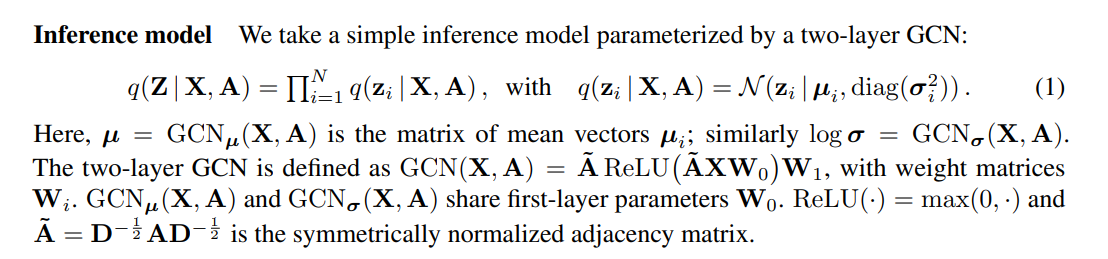

In [4]:
def preprocess_graph(G, node_map):
    # Adjacency matrix 생성
    A = nx.to_numpy_array(G)
    N = A.shape[0]
    # Feature matrix 생성
    X = np.array([node_map[node] for node in G.nodes()])
    X = normalize(X, axis=1, norm='l2')
    # Degree matrix 생성
    D = np.diag(np.sum(A, axis=1))
    # Degree matrix의 제곱근 역행렬 계산
    D_sqrt_inv = np.linalg.inv(np.sqrt(D))
    # L = D^(-1/2) * A * D^(-1/2)
    L = D_sqrt_inv @ A @ D_sqrt_inv
    return A, X, L

A, X, L = preprocess_graph(G, node_map)

# 
# 4.
### V GAE 설계

In [5]:
# Define Graph Autoencoder model
class GraphAutoencoder(Model):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(GraphAutoencoder, self).__init__()
        self.encoder = Dense(hidden_dim, activation='relu')
        self.latent = Dense(latent_dim, activation='linear')
        self.decoder = Dense(input_dim, activation='sigmoid')
    def call(self, inputs):
        X, L = inputs
        LX = tf.matmul(L, X)
        H = self.encoder(LX)
        Z = self.latent(H)
        A_hat = tf.matmul(Z, Z, transpose_b=True)  # 인접 행렬 예측
        return A_hat

# 
# 5. 
### 하이퍼 파라미터 부여 및 학습

In [6]:
input_dim = X.shape[1]
hidden_dim = 32
latent_dim = 16  # 16차원 latent space
gae = GraphAutoencoder(input_dim, hidden_dim, latent_dim)

2024-10-04 07:50:13.832642: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24315 MB memory:  -> device: 0, name: NVIDIA A100 80GB PCIe, pci bus id: 0000:3b:00.0, compute capability: 8.0


In [7]:
# Compile and train the model
optimizer = Adam(learning_rate=0.01)
gae.compile(optimizer=optimizer, loss='mse')
epochs = 200
batch_size = X.shape[0]  # 모든 노드를 한 번에 학습
gae.fit([X, L], A, epochs=epochs, batch_size=batch_size)

Epoch 1/200


2024-10-04 07:50:22.914546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-10-04 07:50:22.951599: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f23bb0809e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-04 07:50:22.951635: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100 80GB PCIe, Compute Capability 8.0
2024-10-04 07:50:23.010418: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-04 07:50:23.116862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-10-04 07:50:23.286840: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pro

1/1 [==============================] - 2s 2s/step - loss: 0.0014
Epoch 2/200
1/1 [==============================] - 0s 32ms/step - loss: 0.0014
Epoch 3/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0014
Epoch 4/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0014
Epoch 5/200
1/1 [==============================] - 0s 36ms/step - loss: 0.0014
Epoch 6/200
1/1 [==============================] - 0s 37ms/step - loss: 0.0014
Epoch 7/200
1/1 [==============================] - 0s 37ms/step - loss: 0.0014
Epoch 8/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0014
Epoch 9/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0014
Epoch 10/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0014
Epoch 11/200
1/1 [==============================] - 0s 35ms/step - loss: 0.0014
Epoch 12/200
1/1 [==============================] - 0s 37ms/step - loss: 0.0014
Epoch 13/200
1/1 [==============================] - 0s 36ms/ste

# 
# 6.
### feature node 추출

In [9]:
# Extract latent space representations
Z = gae.encoder(tf.matmul(L, X)).numpy()
Z = gae.latent(Z).numpy()
print(np.shape(Z))

(2708, 16)


# 
# 7. 
### Spectral clustering을 사용한 시각화
### 1. Spectal embedding 후
### 2. T-sne로 시각화

In [10]:
# Apply Spectral Embedding with an embedding dimension of 128
embedding = SpectralEmbedding(n_components=128, affinity='nearest_neighbors')
Z_sc = embedding.fit_transform(Z)

# Use t-SNE to reduce dimensionality from 128 to 2 for visualization
tsne = TSNE(n_components=2, random_state=0)
Z_2d = tsne.fit_transform(Z_sc)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


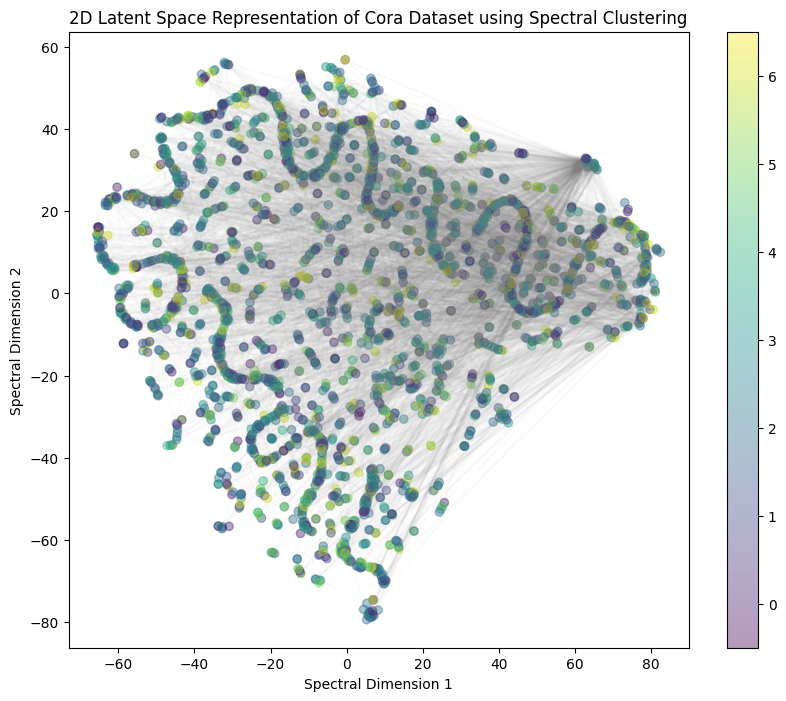

In [14]:
# Visualize 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=encoded_labels, cmap='viridis', alpha=0.5)
plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)))
plt.clim(-0.5, len(label_encoder.classes_) - 0.5)

# Add citation links with adjusted transparency
for edge in G.edges():
    i, j = list(G.nodes).index(edge[0]), list(G.nodes).index(edge[1])
    plt.plot([Z_2d[i, 0], Z_2d[j, 0]], [Z_2d[i, 1], Z_2d[j, 1]], color='gray', alpha=0.02)  # alpha 값 조정
plt.title('2D Latent Space Representation of Cora Dataset using Spectral Clustering')
plt.xlabel('Spectral Dimension 1')
plt.ylabel('Spectral Dimension 2')
plt.show()

# 
### - T-sne를 사용하지 않고 spectral embedding에서 축 2개를 잡아 그린것

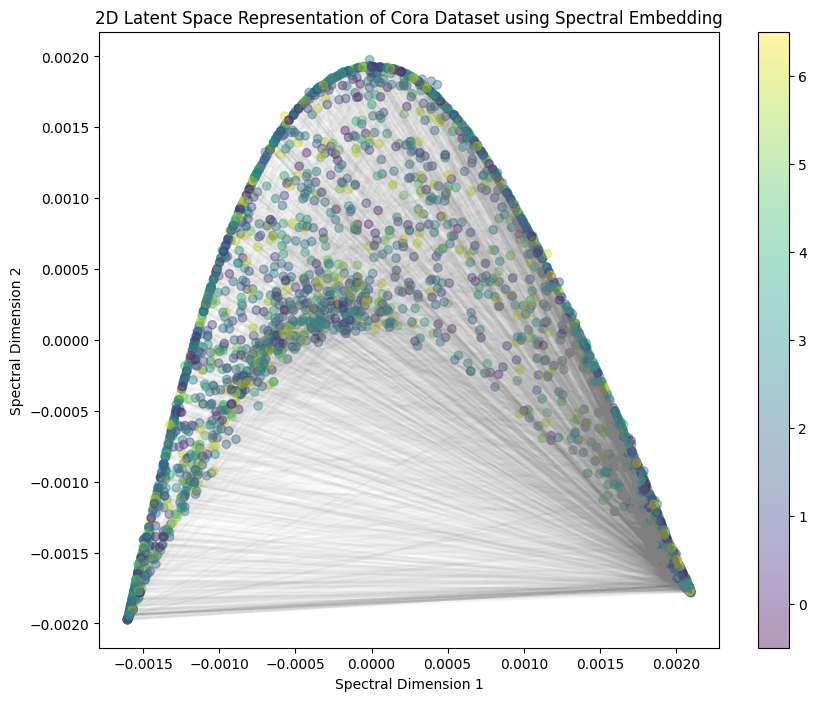

In [15]:
# Apply Spectral Embedding with an embedding dimension of 128
embedding = SpectralEmbedding(n_components=128, affinity='nearest_neighbors')
Z_sc = embedding.fit_transform(Z)

# Use the first two dimensions from the Spectral Embedding for visualization
Z_2d = Z_sc[:, :2]  # 첫 번째와 두 번째 차원 선택

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Visualize 2D latent space
plt.figure(figsize=(10, 8))
scatter = plt.scatter(Z_2d[:, 0], Z_2d[:, 1], c=encoded_labels, cmap='viridis', alpha=0.4)
plt.colorbar(scatter, ticks=range(len(label_encoder.classes_)))
plt.clim(-0.5, len(label_encoder.classes_) - 0.5)

# Add citation links with adjusted transparency
for edge in G.edges():
    i, j = list(G.nodes).index(edge[0]), list(G.nodes).index(edge[1])
    plt.plot([Z_2d[i, 0], Z_2d[j, 0]], [Z_2d[i, 1], Z_2d[j, 1]], color='gray', alpha=0.02)  # alpha 값 조정
plt.title('2D Latent Space Representation of Cora Dataset using Spectral Embedding')
plt.xlabel('Spectral Dimension 1')
plt.ylabel('Spectral Dimension 2')
plt.show()
